# Pipe3: 
## To classify location of damage - front, rear or behind.

In [17]:
import os
import urllib.request
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from keras.layers import Input
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [3]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [4]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, ', val_accuracy:', model_hist['val_accuracy'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

In [26]:
def plot_metrics(hist, stop=32):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
    
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout();
    
    print("Best Model:")
    print_best_model_results(hist)

In [20]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0]*(416) + [1]*(288) + [2]*(272))
    train_labels = to_categorical(train_labels)
    
    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(73) + [1]*(53) + [2]*(50))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
        
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model,fit.history

In [19]:
train_labels

NameError: name 'train_labels' is not defined

In [7]:
def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))
    
    top_model.load_weights(top_model_weights_path)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history

In [8]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    pred_labels = [0 if i<0.5 else 1 for i in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

## Image dataset details

In [23]:
location = '../data3'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'
model1 = location+'/bottleneck_fc_model.h5'
train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 976
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 176

img_width, img_height = 256,256
epochs = 32
batch_size = 16

In [10]:
save_bottleneck_features()

Found 1840 images belonging to 2 classes.


/var/folders/j1/vm8wnhzj1xx95r_k8mczqpwr0000gn/T/ipykernel_32344/1273678277.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = model.predict_generator(generator, nb_train_samples//batch_size)


Found 460 images belonging to 2 classes.


/var/folders/j1/vm8wnhzj1xx95r_k8mczqpwr0000gn/T/ipykernel_32344/1273678277.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples//batch_size)


In [24]:
d3_model, d3_history = train_categorical_model()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

Best Model:
epoch: 4 , val_accuracy: 0.4204545319080353 , val_loss: 1.2028239965438843


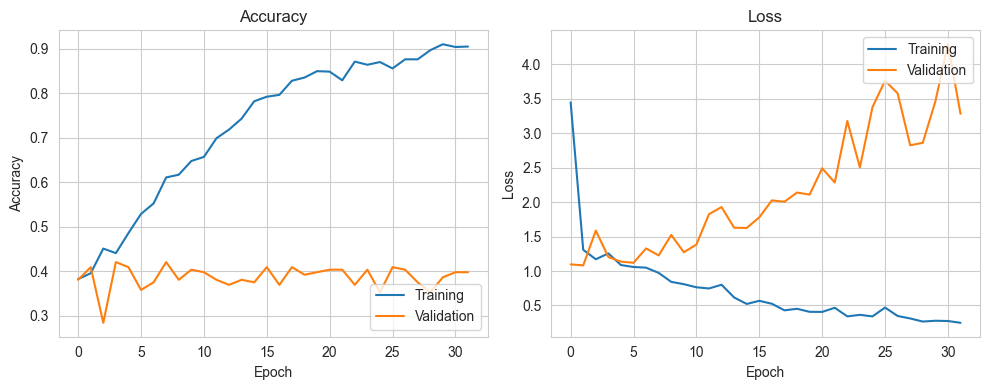

In [27]:
plot_metrics(d3_history)

In [18]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


/var/folders/j1/vm8wnhzj1xx95r_k8mczqpwr0000gn/T/ipykernel_32344/1438658417.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/Users/estelabalboa/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/estelabalboa/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/estelabalboa/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 600, in run_forever

  File "/Users/estelabalboa/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once

  File "/Users/estelabalboa/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/var/folders/j1/vm8wnhzj1xx95r_k8mczqpwr0000gn/T/ipykernel_32344/3689588804.py", line 1, in <module>

  File "/var/folders/j1/vm8wnhzj1xx95r_k8mczqpwr0000gn/T/ipykernel_32344/1438658417.py", line 30, in finetune_categorical_model

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/engine/training.py", line 2889, in fit_generator

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1127, in train_step

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1185, in compute_loss

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy

  File "/Users/estelabalboa/dev/hackathons/delorian-claim/delorian-env/lib/python3.10/site-packages/keras/src/backend.py", line 5581, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[16,3] labels_size=[16,2]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_6589]

In [ ]:
ft_model = load_model('data3/bottleneck_fc_model.h5')

In [ ]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [ ]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

## Pipe3.1

In [ ]:
def pipe31(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'Front', 1:'Rear', 2:'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:",d[key])
    print("Severity assessment complete.")

In [ ]:
Image('https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg')

In [ ]:
pipe31('https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg', model1)

In [ ]:
Image('https://drndata.com/wp-content/uploads/2016/03/car.jpg')

In [ ]:
pipe31('https://drndata.com/wp-content/uploads/2016/03/car.jpg', ft_model)

In [ ]:
Image('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg')

In [ ]:
pipe31('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg', ft_model)